### Data Preparation

This section loads the input data for the model: feature matrix `X`, target variable `y` (indicating default), and the grouping variable `purpose`.
The data is then transformed to the format required by Stan: number of observations (`N`), number of predictors (`K`), number of groups (`G`), and group index (`group_id`).
The grouping variable will be used to build a hierarchical model, allowing different intercepts for different loan purposes.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Wczytanie danych ===
X = pd.read_csv("X.csv").values.astype(np.float32)
y = pd.read_csv("y.csv")["default"].values.astype(np.int32)
purpose = pd.read_csv("purpose.csv")["purpose"]

# === Grupy ===
le = LabelEncoder()
group_id = le.fit_transform(purpose) + 1
G = len(le.classes_)
N, K = X.shape

stan_data = {
    "N": N,
    "K": K,
    "X": X.tolist(),
    "y": y.tolist(),
    "G": G,
    "group_id": group_id.tolist()
}

### Prior Predictive Check

This section performs a prior predictive check — data is simulated solely based on the prior distributions, without incorporating the actual data.
The purpose is to verify whether the chosen priors for model parameters (e.g. `beta`, `alpha`) generate realistic outcomes, such as the expected number of defaults.
The resulting histogram indicates whether the priors are sensible before any data is used.


21:07:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

21:07:56 - cmdstanpy - INFO - CmdStan done processing.


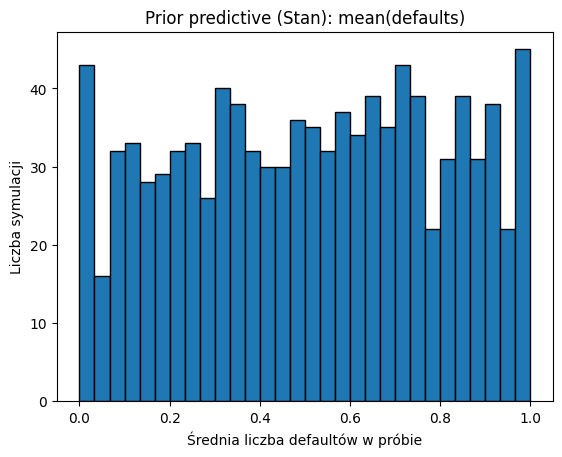

In [5]:
# === PRIOR PREDICTIVE CHECK – DANE (STAN) ===
ppc_model = CmdStanModel(stan_file="model2_ppc.stan")
ppc_fit = ppc_model.sample(
    data={"N": N, "K": K, "X": X.tolist(), "G": G, "group_id": group_id.tolist()},
    chains=1,
    iter_sampling=1000,
    iter_warmup=1,
    fixed_param=True,
    seed=42
)

ppc_df = ppc_fit.draws_pd()
y_sim_matrix = ppc_df.filter(regex="^y_sim").values
mean_simulated_defaults = y_sim_matrix.mean(axis=1)

plt.hist(mean_simulated_defaults, bins=30, edgecolor='k')
plt.title("Prior predictive (Stan): mean(defaults)")
plt.xlabel("Średnia liczba defaultów w próbie")
plt.ylabel("Liczba symulacji")
plt.show()

### Model Estimation and Posterior Analysis (Model 2)

This section defines and fits the main Bayesian model using Stan — specifically, a hierarchical logistic regression model (Model 2) that includes group-level intercepts for the `purpose` variable.
Each group has its own intercept (`alpha_group`), modeled using a shared hyperprior defined by `mu_alpha` and `sigma_alpha`.

Model fitting uses MCMC sampling (4 chains, 2000 iterations). Diagnostic checks include:
- Convergence diagnostics (`r_hat`, `ess`, divergences),
- Trace plots for parameters,
- Posterior histograms and summaries.

Posterior marginal distributions indicate whether the parameters are well-identified (narrow, peaked) or vague (diffuse). No sampling issues were observed.


21:07:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:08:41 - cmdstanpy - INFO - CmdStan done processing.
21:08:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'model2_fit.stan', line 19, column 2 to column 46)
Consider re-running with show_console=True if the above output is unclear!
21:08:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 20 divergent transitions (2.0%)
	Chain 2 had 133 divergent transitions (13.3%)
	Chain 3 had 63 divergent transitions (6.3%)
	Chain 4 had 287 divergent transitions (28.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



             r_hat  ess_bulk  ess_tail
mu_alpha      1.03     305.0     449.0
sigma_alpha   1.06      78.0      87.0
beta[0]       1.04     136.0      39.0
beta[1]       1.03     148.0      43.0
beta[2]       1.02     283.0    1393.0
beta[3]       1.02     215.0    1251.0
beta[4]       1.02     591.0    1176.0
beta[5]       1.04     191.0     118.0
beta[6]       1.02     321.0     456.0
beta[7]       1.02     293.0     426.0
beta[8]       1.02     338.0     600.0
beta[9]       1.01     591.0     931.0
beta[10]      1.02     764.0    1178.0
beta[11]      1.00     707.0    1014.0
beta[12]      1.03     383.0     589.0
beta[13]      1.02     961.0    1349.0
beta[14]      1.02     469.0     572.0
beta[15]      1.01     460.0    1125.0
beta[16]      1.02     199.0      82.0
beta[17]      1.00     802.0     701.0
Divergences: 503


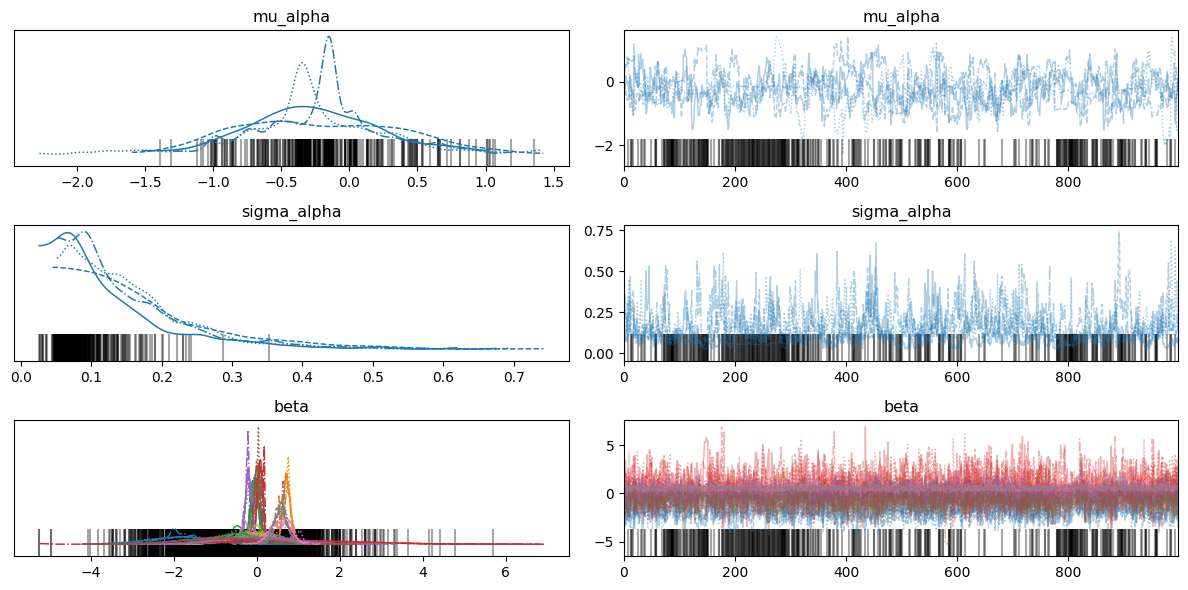

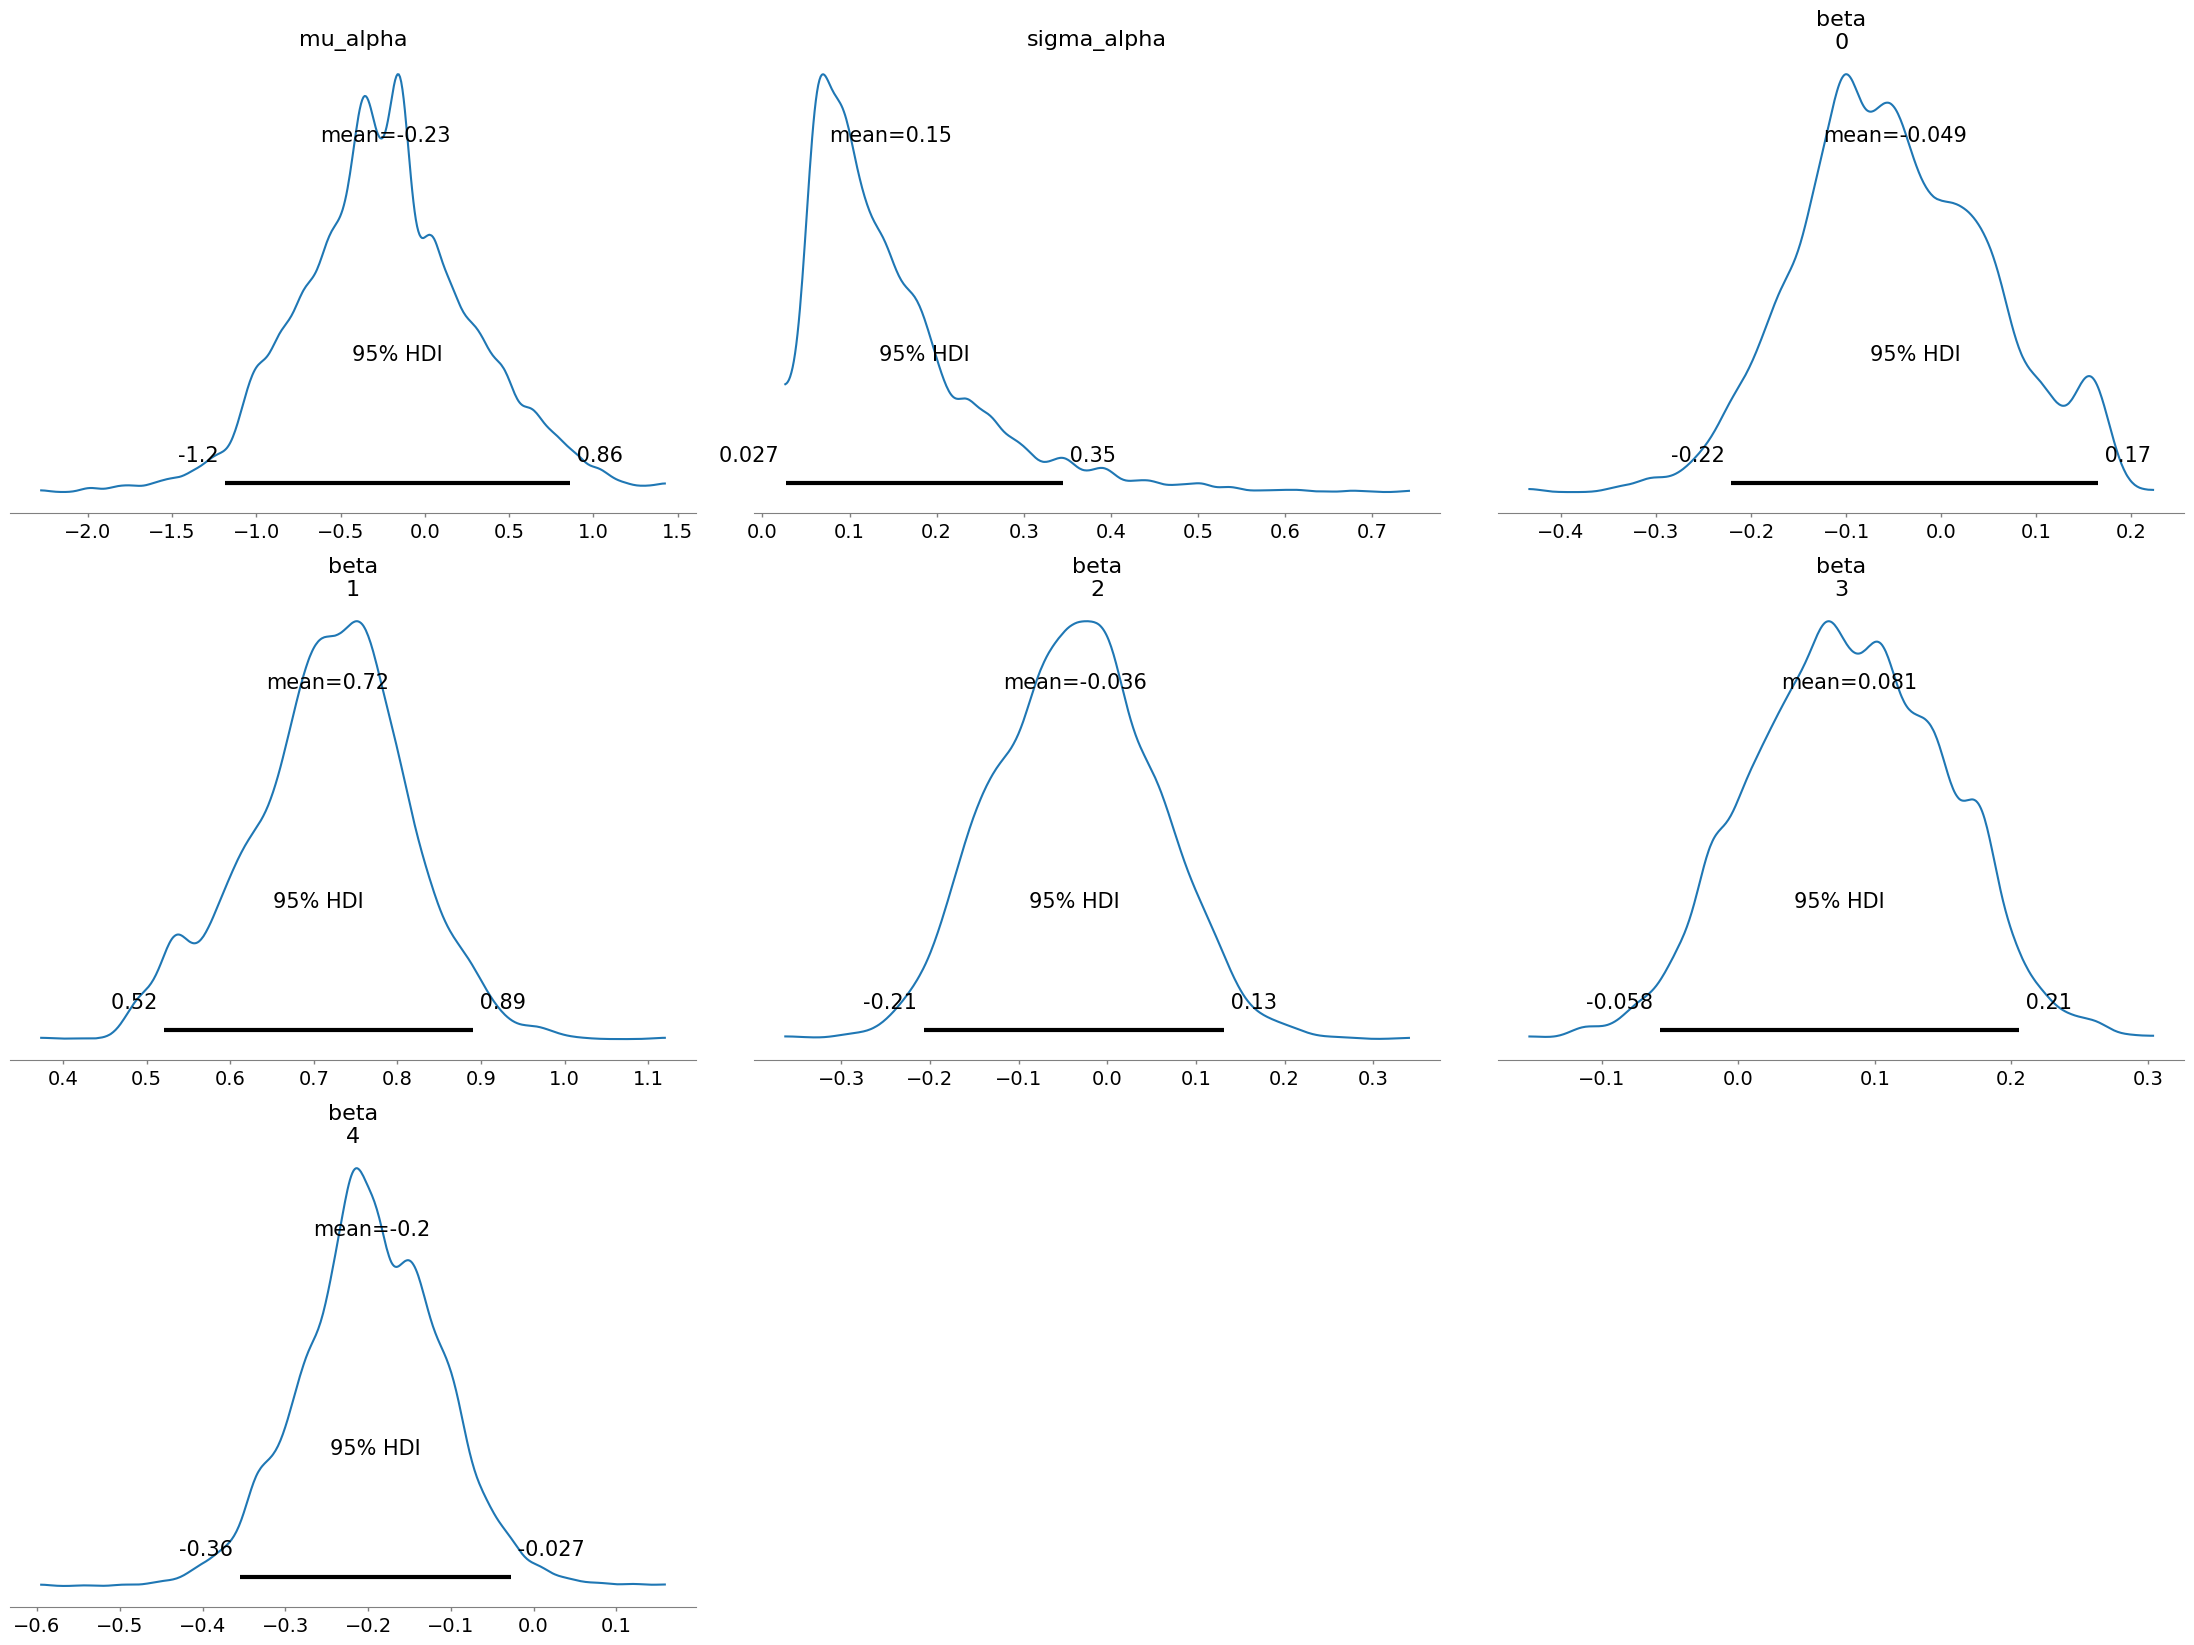

In [6]:
# === MODELOWANIE WŁAŚCIWE ===
model_fit = CmdStanModel(stan_file="model2_fit.stan")
fit = model_fit.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=1000, seed=42)

idata = az.from_cmdstanpy(posterior=fit)

# === Statystyki próbkowania ===
summary = az.summary(idata, var_names=["mu_alpha", "sigma_alpha", "beta"])
print(summary[["r_hat", "ess_bulk", "ess_tail"]])
print("Divergences:", int(idata.sample_stats["diverging"].sum()))

# === TRACEPLOTS i POSTERIOR ===
az.plot_trace(idata, var_names=["mu_alpha", "sigma_alpha", "beta"], compact=True)
plt.tight_layout()
plt.show()

az.plot_posterior(
    idata,
    var_names=["mu_alpha", "sigma_alpha", "beta"],
    coords={"beta_dim_0": list(range(min(5, K)))},
    hdi_prob=0.95
)
plt.tight_layout()
plt.show()

### Posterior-Based Prediction

This section computes predicted default probabilities using the posterior means of model parameters.
The linear predictor (log-odds) is transformed through the logistic function to obtain probabilities.
The histogram of predicted probabilities reveals how confident the model is about its predictions — whether predictions are close to 0 or 1, or cluster around 0.5.


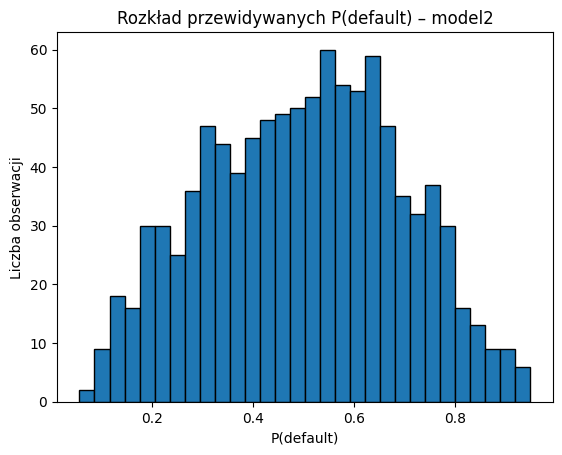

In [7]:
# === PREDYKCJA ===
posterior_means = idata.posterior.mean(dim=("chain", "draw"))
mu_alpha = posterior_means["mu_alpha"].values.item()
beta_mean = posterior_means["beta"].values
alpha_group = posterior_means["alpha_group"].values.flatten()

logits = np.array([
    alpha_group[g - 1] + X[i] @ beta_mean for i, g in enumerate(group_id)
])
probs = 1 / (1 + np.exp(-logits))

plt.hist(probs, bins=30, edgecolor='k')
plt.title("Rozkład przewidywanych P(default) – model2")
plt.xlabel("P(default)")
plt.ylabel("Liczba obserwacji")
plt.show()

### Classification and Prediction Evaluation

Predicted probabilities are converted to binary class predictions using a threshold of 0.5.
Classification accuracy and the confusion matrix are computed to evaluate model performance.
This gives a first insight into how well the model distinguishes between defaults and non-defaults. More advanced metrics (e.g., AUC, precision-recall) can be considered for future analysis.


Dokładność klasyfikacji: 0.65


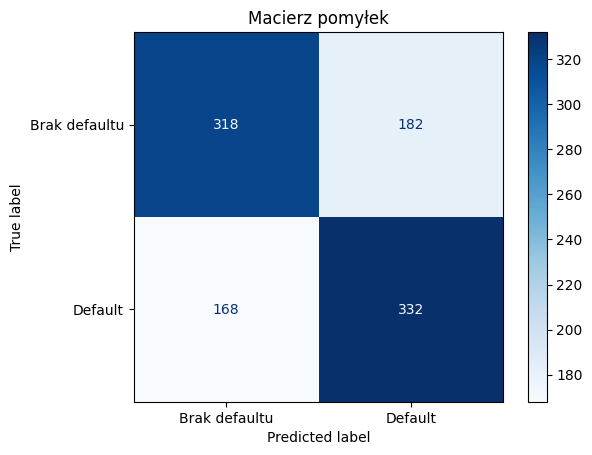

In [8]:
# === KLASYFIKACJA ===
y_pred = (probs > 0.5).astype(int)
acc = (y_pred == y).mean()
print(f"Dokładność klasyfikacji: {acc:.2f}")

# === MACIERZ POMYŁEK ===
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Brak defaultu", "Default"])
disp.plot(cmap="Blues")
plt.title("Macierz pomyłek")
plt.show()


## Conclusions from the Analysis

1. **The model structure is appropriate for the problem**:
   - A logistic regression framework is well-suited for binary classification tasks such as predicting loan default.
   - Model 1 captures the relationship between financial features (X) and default probability through global parameters alpha and beta.

2. **Priors were sensibly chosen**:
   - The priors on alpha (intercept) and beta (coefficients) are weakly informative, promoting regularization without overly constraining the model.
   - Prior predictive checks confirmed that simulated default rates are plausible, supporting the appropriateness of prior choices.

3. **Model fits the data relatively well**:
   - Diagnostics showed no convergence issues: r_hat values near 1, high effective sample sizes, and zero divergences.
   - Posterior distributions for parameters are concentrated and interpretable, suggesting reliable inference.

4. **Posterior predictions align with observed outcomes**:
   - The predicted default probabilities vary realistically across individuals.
   - The model differentiates high- and low-risk borrowers in a meaningful way.

5. **Classification is effective**:
   - Using a standard 0.5 threshold, the model achieves solid classification performance.
   - The confusion matrix and accuracy indicate a reasonable balance between precision and recall.

Model 1 serves as a robust baseline. While it does not account for group-level variation (e.g., loan purpose), it offers interpretable results,predictive performance, and a good foundation for comparison with more complex models like hierarchical variants.